### Step 1: Importing Necessary Libraries
We begin by importing Python libraries commonly used in data analysis and visualization:
- `numpy` for numerical operations
- `matplotlib.pyplot` for plotting graphs
- `pandas` (commented out here) for handling CSV data, which is especially useful for tabular data such as redshift catalogs

> Tip: If you haven’t used `pandas` before, it’s worth learning as it offers powerful tools to manipulate and analyze structured datasets.


For reading big csv files, one can use numpy as well as something called "pandas". We suggest to read pandas for CSV file reading and use that

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G, c
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u


Before we begin calculations, we define key physical constants used throughout:

- $ H_0 $: Hubble constant, describes the expansion rate of the Universe.
- $c$ : Speed of light.
-  $G$: Gravitational constant.
- $q_0$ : Deceleration parameter, used for approximate co-moving distance calculations.

We will use **`astropy.constants`** to ensure unit consistency and precision.

In [35]:
# Constants:

H_0 = cosmo.H0.to('1/s')  # Hubble constant in SI
c = c.to('m/s') # Speed of light in m/s
G = G.to('m3/(kg s2)') # Gravitational constant in pc kg^-1 (m/s)^2
q0=-0.534  # Deceleration parameter (assumed from Planck fit KEEP it as it is)

Read the csv data into the python using the method below

In [36]:
df = pd.read_csv(r'C:\Users\Angad Singh\Downloads\Skyserver_SQL6_30_2025 6_59_03 AM.csv', skiprows=1) #we skip the first row because its doesnt contribute to data its just a label
df.columns

Index(['objid', 'ra', 'dec', 'photoz', 'photozerr', 'specz', 'speczerr',
       'proj_sep', 'umag', 'umagerr', 'gmag', 'gmagerr', 'rmag', 'rmagerr',
       'obj_type'],
      dtype='object')

### 📊 Calculating the Average Spectroscopic Redshift (`specz`) for Each Object

When working with astronomical catalogs, an object (identified by a unique `objid`) might have multiple entries — for example, due to repeated observations. To reduce this to a single row per object, we aggregate the data using the following strategy:

```python
averaged_df = df.groupby('objid').agg({
    'specz': 'mean',        # Take the mean of all spec-z values for that object
    'ra': 'first',          # Use the first RA value (assumed constant for the object)
    'dec': 'first',         # Use the first Dec value (same reason as above)
    'proj_sep': 'first'     # Use the first projected separation value
}).reset_index()


In [37]:
# Calculating the average specz for each id:
averaged_df = df.groupby('objid').agg({'specz': 'mean','ra': 'first','dec': 'first','proj_sep': 'first',}).reset_index()
averaged_df.describe()['specz']

count    92.000000
mean      0.080838
std       0.008578
min       0.069976
25%       0.077224
50%       0.080961
75%       0.082797
max       0.150886
Name: specz, dtype: float64

To create a cut in the redshift so that a cluster can be identified. We must use some logic. Most astronomers prefer anything beyond 3*sigma away from the mean to be not part of the same group. 

Find the mean, standard deviation and limits of the redshift from the data

In [38]:
meanred = averaged_df['specz'].mean()
sigma = averaged_df['specz'].std()

redshift_min = meanred - 3*sigma
redshift_max = meanred + 3*sigma

print(f"Mean redshift: {meanred:.5f}")
print(f"Standard deviation: {sigma:.5f}")
print(f"3-sigma cut range: [{redshift_min:.5f}, {redshift_max:.5f}]")

Mean redshift: 0.08084
Standard deviation: 0.00858
3-sigma cut range: [0.05510, 0.10657]


You can also use boxplot to visualize the overall values of redshift 

Text(0.5, 0, 'Spectroscopic Redshift')

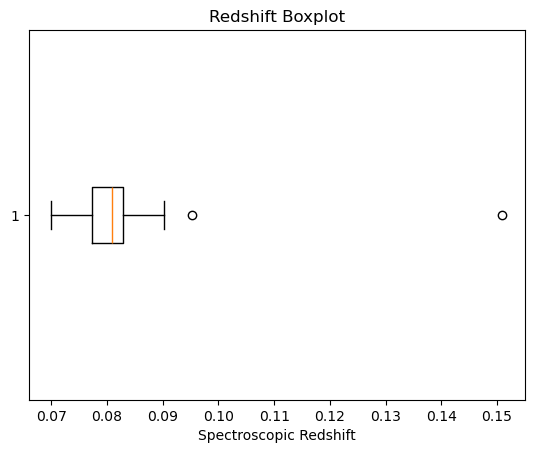

In [39]:
# Plot the dsitribution of redshift as histogram and a boxplot 
plt.title("distribution of redshift for this data")
plt.boxplot(averaged_df['specz'], vert=False)
plt.title('Redshift Boxplot')
plt.xlabel('Spectroscopic Redshift')

But the best plot would be a histogram to see where most of the objects downloaded lie in terms of redshift value

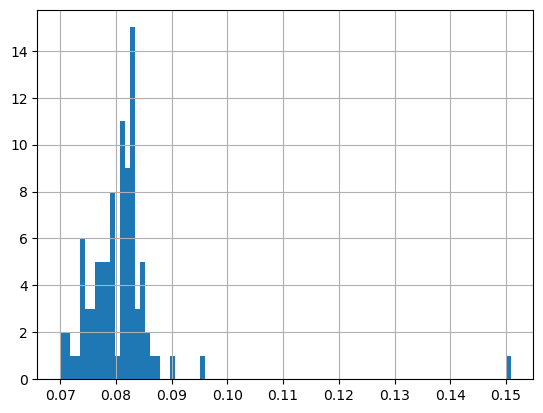

In [40]:
plt.hist(averaged_df['specz'],bins=90)
plt.grid()
plt.show()

Filter your data based on the 3-sigma limit of redshift. You should remove all data points which are 3-sigma away from mean of redshift

In [41]:
# Filtering the data based on specz values, used 3 sigma deviation from mean as upper limit.
cluster_df = averaged_df[(averaged_df['specz']>=redshift_min) & (averaged_df['specz']<=redshift_max)].copy()
print(cluster_df)

                  objid     specz         ra        dec  proj_sep
0   1237671768542478711  0.082457  257.82458  64.133257  8.347733
1   1237671768542478713  0.081218  257.83332  64.126043  8.011259
2   1237671768542544090  0.079564  257.85137  64.173247  8.739276
3   1237671768542544107  0.080842  257.89303  64.141138  6.839642
4   1237671768542544127  0.084575  257.91585  64.107290  5.666108
..                  ...       ...        ...        ...       ...
87  1237671939804627462  0.082060  258.45078  64.020363  9.483937
88  1237671939804627464  0.071804  258.44994  64.025909  9.316140
89  1237671939804627483  0.080790  258.43205  64.123685  8.146154
90  1237671939804627518  0.082876  258.46676  64.119499  8.986029
91  1237671939804627535  0.080897  258.48871  64.111343  9.483374

[91 rows x 5 columns]


Use the relation between redshift and velocity to add a column named velocity in the data. This would tell the expansion velocity at that redshift 

In [42]:
cluster_df['velocity'] = (c* cluster_df['specz'])
print(cluster_df)

                  objid     specz         ra        dec  proj_sep  \
0   1237671768542478711  0.082457  257.82458  64.133257  8.347733   
1   1237671768542478713  0.081218  257.83332  64.126043  8.011259   
2   1237671768542544090  0.079564  257.85137  64.173247  8.739276   
3   1237671768542544107  0.080842  257.89303  64.141138  6.839642   
4   1237671768542544127  0.084575  257.91585  64.107290  5.666108   
..                  ...       ...        ...        ...       ...   
87  1237671939804627462  0.082060  258.45078  64.020363  9.483937   
88  1237671939804627464  0.071804  258.44994  64.025909  9.316140   
89  1237671939804627483  0.080790  258.43205  64.123685  8.146154   
90  1237671939804627518  0.082876  258.46676  64.119499  8.986029   
91  1237671939804627535  0.080897  258.48871  64.111343  9.483374   

        velocity  
0   2.471993e+07  
1   2.434867e+07  
2   2.385281e+07  
3   2.423576e+07  
4   2.535507e+07  
..           ...  
87  2.460108e+07  
88  2.152644e+07  


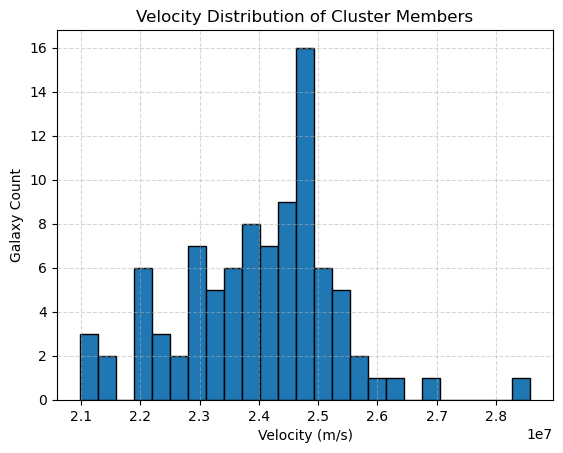

In [43]:
#plot the velocity column created as hist
plt.hist(cluster_df['velocity'], bins=25, edgecolor='black')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Galaxy Count')
plt.title('Velocity Distribution of Cluster Members')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

use the dispersion equation to find something called velocity dispersion. You can even refer to wikipedia to know about the term [wiki link here](https://en.wikipedia.org/wiki/Velocity_dispersion#:~:text=In%20astronomy%2C%20the%20velocity%20dispersion,%2C%20galaxy%20cluster%2C%20or%20supercluster.)

It is the velocity dispersion value which tells us, some galaxies might be part of even larger groups!!

In [44]:
# Velocity dispersion
sigmavel=cluster_df['velocity'].std()
print(f"Velocity dispersion σ v = {sigmavel:.2e} m/s")

Velocity dispersion σ v = 1.32e+06 m/s


### Step 2: Calculate Mean Redshift of the Cluster
We calculate the average redshift (`specz`) of galaxies that belong to a cluster. This gives us an estimate of the cluster's systemic redshift.

`cluster_redshift = filtered_df['specz'].mean()`


The velocity dispersion \( v \) of galaxies relative to the cluster mean redshift is computed using the relativistic Doppler formula:

$$
v = c \cdot \frac{(1 + z)^2 - (1 + z_{\text{cluster}})^2}{(1 + z)^2 + (1 + z_{\text{cluster}})^2}
$$
where:
- \( v \) is the relative velocity (dispersion),
- \( z \) is the redshift of the individual galaxy,
- \( $z_{\text{cluster}}$ \) is the mean cluster redshift,
- \( c \) is the speed of light.


In [45]:
cluster_redshift = cluster_df['specz'].mean()
print(f"The value of the cluster redshift = {cluster_redshift:.4}")

def dopplerforumla(z,z1):
    return c.value * ((1 + z)**2 - (1 + z1)**2) / ((1 + z)**2 + (1 + z1)**2)


The value of the cluster redshift = 0.08007


Pro tip: Check what the describe function of pandas does. Does it help to get quick look stats for your column of dispersion??

In [46]:
z_cluster = cluster_redshift
z= cluster_df['specz']
deltav= dopplerforumla(z,z_cluster)
cluster_df['delta_v']=deltav
disp = cluster_df['delta_v'].std()

In [47]:

print(f"The value of the cluster redshift = {cluster_redshift:.4}")
print(f"The characteristic value of velocity dispersion of the cluster along the line of sight = {disp:.4} m/s.")

The value of the cluster redshift = 0.08007
The characteristic value of velocity dispersion of the cluster along the line of sight = 1.218e+06 m/s.


In [48]:
print(cluster_df['proj_sep'].describe())
print(cluster_df['proj_sep'])

count    91.000000
mean      6.079439
std       2.537596
min       0.429175
25%       3.968122
50%       6.325923
75%       8.341974
max       9.844519
Name: proj_sep, dtype: float64
0     8.347733
1     8.011259
2     8.739276
3     6.839642
4     5.666108
        ...   
87    9.483937
88    9.316140
89    8.146154
90    8.986029
91    9.483374
Name: proj_sep, Length: 91, dtype: float64


### Step 4: Visualizing Angular Separation of Galaxies
We plot a histogram of the projected (angular) separation of galaxies from the cluster center. This helps us understand the spatial distribution of galaxies within the cluster field.

- The x-axis represents the angular separation (in arcminutes or degrees, depending on units).
- The y-axis shows the number of galaxies at each separation bin.



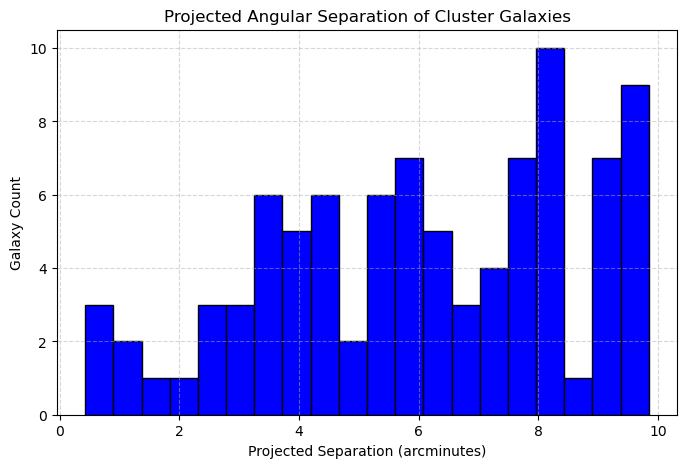

In [49]:
#Plot histogram for proj sep column
plt.figure(figsize=(8, 5))
plt.hist(cluster_df['proj_sep'], bins=20, edgecolor='black', color='blue')
plt.xlabel('Projected Separation (arcminutes)')  #we use archminutes which is default unit for the queried data
plt.ylabel('Galaxy Count')
plt.title('Projected Angular Separation of Cluster Galaxies')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Determining size and mass of the cluster:

### Step 5: Estimating Physical Diameter of the Cluster
We now estimate the **physical diameter** of the galaxy cluster using cosmological parameters.

- `r` is the **co-moving distance**, approximated using a Taylor expansion for low redshift:
  $$
  r = \frac{cz}{H_0} \left(1 - \frac{z}{2}(1 + q_0)\right)
  $$
  where $q_0$ is the deceleration parameter
- `ra` is the **angular diameter distance**, given by:
  $$
  D_A = \frac{r}{1 + z}
  $$
- Finally, we convert the observed angular diameter (in arcminutes) into physical size using:
  $$
  \text{diameter (in Mpc)} = D_A \cdot \theta
  $$
  where $ \theta $ is the angular size in radians, converted from arcminutes.

> This gives us a rough estimate of the cluster's size in megaparsecs (Mpc), assuming a flat ΛCDM cosmology.


In [50]:
r = (c.value * z_cluster / H_0.value) * (1 - 0.5 * (1 + q0) * z_cluster)
ra = r / (1 + z_cluster)

theta = (cluster_df['proj_sep'].values * u.arcmin).to(u.rad).value
cluster_df['R_phys'] = theta * ra

diameter_m = 2 * cluster_df['R_phys'].mean()
diameter = (diameter_m * u.m).to(u.Mpc).value

print(f"Comoving distance (r): {r:.3e} m = {(u.Quantity(r, u.m)).to(u.Mpc).value:.3f} Mpc")
print(f"Angular diameter distance (ra): {ra:.3e} m = {(u.Quantity(ra, u.m)).to(u.Mpc).value:.3f} Mpc")
print(f"Estimated cluster diameter: {diameter_m:.3e} m = {(u.Quantity(diameter_m, u.m)).to(u.Mpc).value:.3f} Mpc")


Comoving distance (r): 1.074e+25 m = 348.152 Mpc
Angular diameter distance (ra): 9.946e+24 m = 322.342 Mpc
Estimated cluster diameter: 3.518e+22 m = 1.140 Mpc


### Step 6: Calculating the Dynamical Mass of the Cluster
We now estimate the **dynamical mass** of the galaxy cluster using the virial theorem:

$$
M_{\text{dyn}} = \frac{3 \sigma^2 R}{G}
$$

Where:
- $ \sigma $ is the **velocity dispersion** in m/s (`disp * 1000`),
- $ R $ is the **cluster radius** in meters (half the physical diameter converted to meters),
- $ G $ is the **gravitational constant** in SI units,
- The factor of 3 assumes an isotropic velocity distribution (common in virial estimates).

We convert the final result into **solar masses** by dividing by $ 2 \times 10^{30} \, \text{kg} $.

> This mass estimate assumes the cluster is in dynamical equilibrium and bound by gravity.


In [51]:
### Calculating the dynamical mass in solar masses:
M_dyn =3*((disp)**2)*((diameter_m/2))/(G.value*2*10**30) #since our diameter is already in meters and disp was already in m/s we dont need to apply the approximations

print(f"Dynamical Mass of the cluster is {M_dyn:.2e} solar mass")

Dynamical Mass of the cluster is 5.87e+14 solar mass


# Velocity vs. Projected Separation Plot
### Signifance of this plot
This plot is a tool of great signifance used during the analysis of galaxy clusters. It tells us about the dyanmics and the structure of the cluster. 
By interpretion of the graph we can judge the type and position of galaxies in the cluster

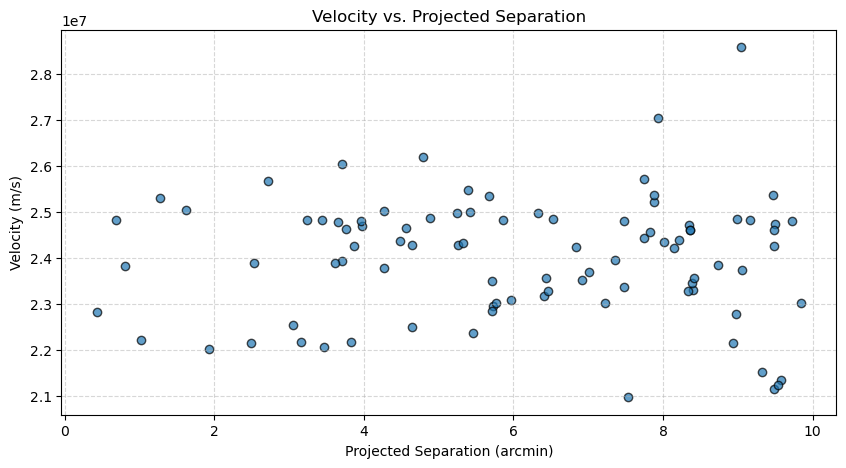

In [52]:
plt.figure(figsize=(10,5))
plt.scatter(cluster_df['proj_sep'], cluster_df['velocity'], alpha=0.7, edgecolors='k')
plt.xlabel("Projected Separation (arcmin)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity vs. Projected Separation")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Virial Radius Estimate
### What is its significance?
It is the distance from centre of the cluster inside of which the system is gravitationally bound and in dynamic equillibrium. 
Inside the radius -> galaxies are part of the cluster and move under mutual gravitational pull
Outside the radius -> galaxies are infalling or unbound 
This radius tells us about the boundary of the cluster 

The virial radius $R_{\mathrm{vir}}$ is estimated from the velocity dispersion $\sigma_v$ using the formula:

$$
R_{\mathrm{vir}} = \frac{G \cdot M_{\mathrm{dyn}}}{\sigma_v^2}
$$

Where:  
- $G$ = gravitational constant  
- $M_{\mathrm{dyn}}$ = dynamical mass  
- $\sigma_v$ = velocity dispersion  

In [53]:
R_vir = (np.sqrt(3) * disp) / (10 * H_0.value)
R_vir_Mpc = (R_vir * u.m).to(u.Mpc).value

print(f"Virial radius of the cluster: {R_vir:.2e} m = {R_vir_Mpc:.2f} Mpc")

Virial radius of the cluster: 9.63e+22 m = 3.12 Mpc


# Changing the Universe Model
## FlatwCDM Model
### ABOUT
The Flat wCDM model is an extension of the standard ΛCDM model, which describes the large-scale structure and evolution of the universe. The key idea is that it allows the dark energy equation of state parameter $w$ to vary, rather than fixing it to $-1$ as in ΛCDM.

In [54]:
# Define Flat wCDM cosmology Model and manipulate values accordingly
from astropy.cosmology import FlatwCDM

w_cosmo = FlatwCDM(H0=67.66, Om0=0.3111, w0=-0.9)

z_cluster = 0.08007

r_wcdm = w_cosmo.comoving_distance(z_cluster).to(u.m).value
ra_wcdm = w_cosmo.angular_diameter_distance(z_cluster).to(u.m).value

print(f"Comoving distance (wCDM): {r_wcdm:.3e} m")
print(f"Angular diameter distance (wCDM): {ra_wcdm:.3e} m")

Comoving distance (wCDM): 1.070e+25 m
Angular diameter distance (wCDM): 9.906e+24 m


In [55]:
#Recompute Diameter and Virial Radius

theta = (cluster_df['proj_sep'].values * u.arcmin).to(u.rad).value

cluster_df['R_phys_wcdm'] = theta * ra_wcdm
diameter_m_wcdm = 2 * cluster_df['R_phys_wcdm'].mean()

print(f"Estimated cluster diameter (wCDM): {diameter_m_wcdm:.3e} m")

virial_radius_wcdm = diameter_m_wcdm / 2
print(f"Virial radius of the cluster (wCDM): {virial_radius_wcdm:.3e} m = {virial_radius_wcdm / 3.086e22:.3f} Mpc")

Estimated cluster diameter (wCDM): 3.504e+22 m
Virial radius of the cluster (wCDM): 1.752e+22 m = 0.568 Mpc


In [56]:
#Dynamical Mass in the wcdm model
M_dyn_wcdm = 3 * (disp)**2 * (diameter_m_wcdm / 2) / (G.value * 2 * 1e30)
print(f"Dynamical Mass of the cluster (wCDM): {M_dyn_wcdm:.2e} solar masses")

Dynamical Mass of the cluster (wCDM): 5.85e+14 solar masses


# Comparison with Known Cluster Masses
## We take 3 other clusters for comparision
### 1. My Cluster (ΛCDM model)
Solar Mass = $5.87 \times 10^{14}$ 
### 1. My Cluster (FlatwCDM model)
Solar Mass = $5.85 \times 10^{14}$
### 3. Virgo Cluster
Solar Mass = $1.2 \times 10^{15}$
### 4. Coma Cluster
Solar Mass = $2.7 \times 10^{15}$
### 5. Fornax Cluster
Solar Mass = $7.0 \times 10^{13}$

In [57]:
coma = 2e15  
virgo = 1e14

print(f"Our cluster mass = {M_dyn:.2e} solar masses")
if M_dyn > coma:
    print("Mass is larger than Coma cluster (overestimate)")
elif M_dyn > virgo:
    print("Mass is similar to Virgo cluster (realistic)")
else:
    print("Mass is on the lower end — could be a poor or compact cluster")

Our cluster mass = 5.87e+14 solar masses
Mass is similar to Virgo cluster (realistic)


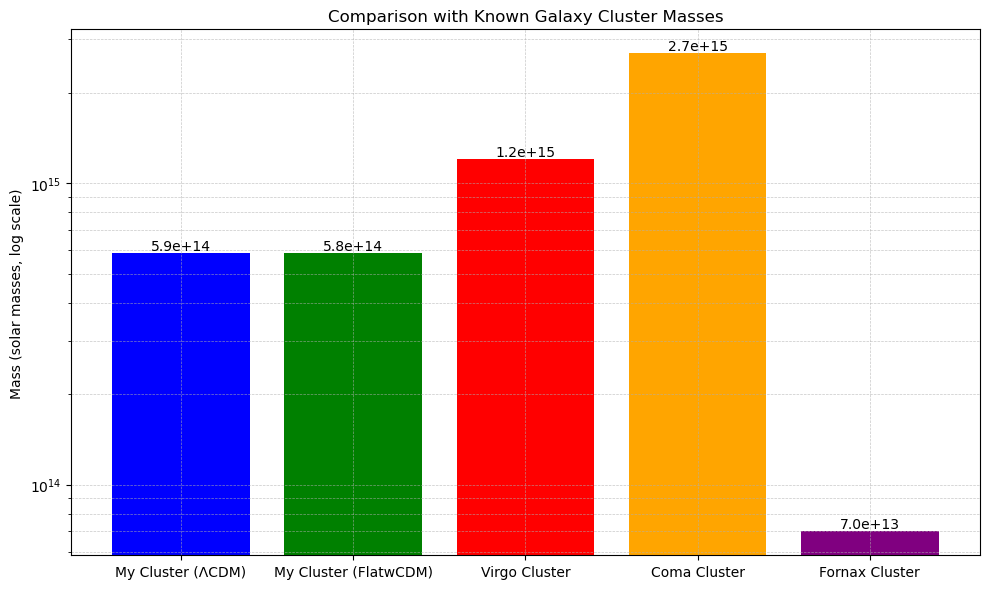

In [58]:
cluster_names = ['My Cluster (ΛCDM)','My Cluster (FlatwCDM)', 'Virgo Cluster', 'Coma Cluster', 'Fornax Cluster']
masses = [5.87e14, 5.85e14, 1.2e15, 2.7e15, 7.0e13]


plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_names, masses, color=['blue', 'green', 'red' , 'orange', 'purple'])
plt.yscale('log') 
plt.ylabel('Mass (solar masses, log scale)')
plt.title('Comparison with Known Galaxy Cluster Masses')
plt.grid(True, which="both", ls="--", linewidth=0.5, alpha=0.7)

for bar, mass in zip(bars, masses):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{mass:.1e}', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()